# Outline
0. Generating ergodic trajectories
1. Trajectory/Distribution perturbation vs Fourier Coefficient
    - induced distribution from trajectory
    - distribution vs fourier coefficient
2. Fourier coefficient perturbation vs ergodic metric perturbation

In [1]:
distribution_name = "paper_peaks" #"close_peaks" #"one_peak"
from enum import Enum
class PerturbationType(Enum):
    UNIFORM = 1
    GAUSSIAN = 2
p_type = PerturbationType.UNIFORM
perturbation_type = p_type.name
perturbation_amts = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1]
time_steps = 100
K = 5
system_name = "casadi"
compute_mu = False

In [2]:
import numpy as np
from probability_distribution import *
U_shape = (1,1)
all_k = list(np.ndindex(*[K]*len(U_shape)))

# 0. Generate ergodic trajectories

## 0.a. Define probability distribution $\mu$

In [3]:
mu = mu_gaussians([(np.array([0.25, 0.75]), 0.025), (np.array([0.6, 0.4]), 0.025)], U_shape) # paper peaks
# mu = mu_gaussians([(np.array([0.25, 0.75]), 0.025), (np.array([0.5, 0.5]), 0.025)], U_shape) # close peaks
mu = mu_normalize(mu, U_shape)
mu_display2D(mu, U_shape, title=f"mu/{distribution_name}_original")

In [4]:
# defining probability distribution mu

# calculating fourier coefficients of probability distribution mu
from fourier_functions import *
import pickle

ff = Fourier_Functions(mu, U_shape, K, compute_mu=compute_mu)
if compute_mu:
    mu_k = {}
    for k in ff:
        mu_k[k] = ff[k]['mu_k']

    with open(f'mu/{distribution_name}_{K}.pkl', 'wb') as handle:
        pickle.dump(mu_k, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(f'mu/{distribution_name}_{K}.pkl', 'rb') as handle:
        mu_k = pickle.load(handle)
    for k in ff:
        ff[k]['mu_k'] = mu_k[k]

original_mu = mu 
# mu = fourier_coefficient2distribution(ff, all_k, c_k=None)

if compute_mu:
    mu_display2D(original_mu, U_shape, title=f"mu/{distribution_name}_original")
    mu_display2D(mu, U_shape, title=f"mu/{distribution_name}_fouriered")


In [5]:
# mu_display2D(original_mu, U_shape, title=f"mu/{distribution_name}_original")
# mu_display2D(mu, U_shape, title=f"mu/{distribution_name}_fouriered")
# mu(np.array([0.9, 0.1]))

## 0.b. Define agent system

In [6]:
from ergodic_agents import *
from mm_agent import *
from casadi_agent import * 

# agent1 = MMAgent1(0, np.array([0.2, 0.3]), 0.5, all_k, U_shape, ff, eps=1e-5)
agent1 = CasadiAgent(0, np.array([0.2, 0.3]), 0.5, all_k, U_shape, ff, eps=1e-5)
system = AgentSystem([agent1], mu, U_shape, ff, K)
agent1.time_horizon = 30

## 0.c. Generate Vanilla Ergodic Trajectory $x$

In [7]:
t = 0
delta_t = 0.1
for i in range(time_steps):
    t = i * delta_t
    system.evolve(t, delta_t)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.87ms (754.72us)  18.86ms (754.55us)        25
       nlp_g  |   1.12ms ( 44.92us)   1.12ms ( 44.88us)        25
  nlp_grad_f  |  36.16ms (  1.72ms)  35.99ms (  1.71ms)        21
  nlp_hess_l  |   3.80 s (199.96ms)   3.78 s (199.06ms)        19
   nlp_jac_g  |   3.86ms (184.05us)   3.85ms (183.12us)        21
       total  |   3.90 s (  3.90 s)   3.88 s (  3.88 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  20.19ms (878.04us)  20.25ms (880.32us)        23
       nlp_g  |   

In [8]:
filename = f"robustness/system={system_name}_mu={distribution_name}_K={K}_T={time_steps}"
description = f"{system_name} on {distribution_name}"

system.visualize_trajectory(filename, description)
system.visualize_ergodicity(filename)

[([], [])]


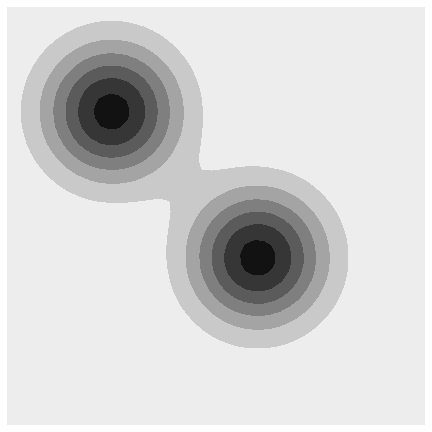

In [8]:
system.visualize2d_2(f"system={system_name}_mu={distribution_name}_K={K}_T={time_steps}", plot_c_k=False)

[([], [])]


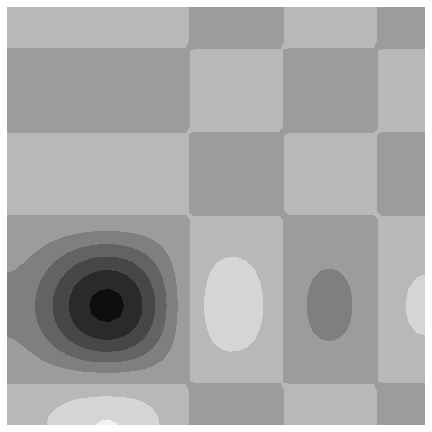

In [9]:
system.visualize2d_2(f"c_k_system={system_name}_mu={distribution_name}_K={K}_T={time_steps}", plot_c_k=True)

# 1. Trajectory/distribution perturbation vs Fourier coefficient

In [9]:
perturbation = {p_amt:{ "mu_k": None, 
                        "trajectory": None, 
                        "c_k": None} for p_amt in perturbation_amts}

## 1.a. induced distribution from trajectory

In [10]:
for _time_steps in [time_steps//4, time_steps//2, time_steps]:
    _filename = f"robustness/system={system_name}_mu={distribution_name}_K={K}_T={_time_steps}"
    spatial_distribution = fourier_coefficient2distribution(ff, all_k, c_k=system.c_k_log[_time_steps])
    mu_display2D(spatial_distribution, U_shape, title=f"{_filename}_induced_spatial_distribution")

    trajectories = [agent.x_log[:_time_steps] for agent in system.agents]
    visualize_trajectory(f"{_filename}_induced_spatial_distribution_with", 
                     f"{system_name} induced spatial distribution with trajectory", 
                     U_shape, trajectories, spatial_distribution)

## 1.b. distribution perturbations vs Fourier coefficients

In [11]:
agent1.x_log

[array([0.2, 0.3]),
 array([0.21410599, 0.34796872]),
 array([0.22365892, 0.39704741]),
 array([0.22855217, 0.44680714]),
 array([0.22899712, 0.4968049 ]),
 array([0.2255194 , 0.54668351]),
 array([0.21886542, 0.59623844]),
 array([0.20992238, 0.64543173]),
 array([0.19979894, 0.6943956 ]),
 array([0.19038414, 0.74350039]),
 array([0.18688986, 0.79337674]),
 array([0.20978614, 0.83782311]),
 array([0.25965801, 0.84136649]),
 array([0.30660502, 0.82416646]),
 array([0.34967008, 0.79876349]),
 array([0.38969831, 0.7688023 ]),
 array([0.42730409, 0.73585156]),
 array([0.46289688, 0.70073599]),
 array([0.49669372, 0.66388868]),
 array([0.52871021, 0.62548438]),
 array([0.55871964, 0.58549229]),
 array([0.58613244, 0.5436779 ]),
 array([0.60968394, 0.49957381]),
 array([0.62671598, 0.45256742]),
 array([0.63242763, 0.40290239]),
 array([0.62405447, 0.35363527]),
 array([0.61503062, 0.31412599]),
 array([0.6471834 , 0.30489091]),
 array([0.69697186, 0.30053865]),
 array([0.74694668, 0.299361

In [12]:
assert len(system.agents) == 1
for p_amt in perturbation:
    p_tag = f"perturb={perturbation_type}_amt={p_amt}"
    # trajectory perturbations
    trajectory = np.array(system.agents[0].x_log) 
    if p_type == PerturbationType.UNIFORM:
        radii = p_amt * np.sqrt(np.random.uniform(0, 1, (len(trajectory),)))
        thetas = np.random.uniform(0, 1, (len(trajectory, )))*2*np.pi
        perturb = [radii[i]*np.array([np.cos(thetas[i]), np.sin(thetas[i])]) for i in range(len(trajectory))]
        perturbed_trajectory = trajectory+perturb
    elif p_type == PerturbationType.GAUSSIAN:
        perturbed_trajectory = np.clip(np.random.gaussian(trajectory, p_amt), 0, U_shape)
    else:
        raise RuntimeError
    perturbation[p_amt]["trajectory"] = perturbed_trajectory
    perturbation[p_amt]["c_k"] = {k: sum([ff[k]['f_k'](x) for x in perturbed_trajectory])/len(perturbed_trajectory) for k in ff}

    # original vs perturbed trajectory on original distribution
    visualize_trajectory(f"{filename}_original_vs_perturbed_{p_tag}", 
                     f"{system_name} original vs perturbed trajectory", 
                     U_shape, [trajectory, perturbed_trajectory], mu)

    # induced perturbed distribution with and without trajectory
    # p_spatial_distribution = fourier_coefficient2distribution(ff, all_k, c_k=system.c_k)
    # mu_display2D(spatial_distribution, U_shape, title=f"{filename}_induced_spatial_distribution_{p_tag}")
    
    # trajectories = [agent.x_log for agent in system.agents]
    # visualize_trajectory(f"{filename}_induced_spatial_distribution_{p_tag}_with", 
                    #  f"{system_name} induced spatial distribution with perturbed trajectory ({perturbation_type} {p_amt})", 
                    #  U_shape, trajectories, spatial_distribution)
                     
    # TODO plot trajectory perturbation amount to c_k perturbation amount

    # information distribution perturbations   
    perturbation[p_amt]["mu_k"] = None
# 222 min


# 2. Fourier coefficient perturbation vs ergodic metric perturbation

## 2.a. one shot ergodic metric perturbation

In [13]:
def ergodic_metric(lambda_k, c_k, mu_k):
    return sum([lambda_k[k]*(mu_k[k] - c_k[k])**2 for k in lambda_k])

_lambda_k = {k: ff[k]['lambda_k'] for k in ff}
for p_amt in perturbation:
    perturbation[p_amt]["ergodicity change c_k"] = ergodic_metric(_lambda_k, perturbation[p_amt]["c_k"], mu_k)
#     perturbation[p_amt]["ergodicity change mu_k"] = ergodic_metric(_lambda_k, system.c_k, perturbation[p_amt]["mu_k"])
    perturbation[p_amt]["ergodicity change +"] = ergodic_metric(_lambda_k, {k: system.c_k[k] - p_amt for k in system.c_k}, mu_k)
    perturbation[p_amt]["ergodicity change -"] = ergodic_metric(_lambda_k, {k: system.c_k[k] + p_amt for k in system.c_k}, mu_k)

deltas = [-p for p in perturbation_amts] + perturbation_amts
ergodicities = [perturbation[p_amt]["ergodicity change -"] for p_amt in perturbation] + [perturbation[p_amt]["ergodicity change +"] for p_amt in perturbation]
plt.figure()
plt.plot(deltas, ergodicities, 'o')
deltas_sorted = sorted(deltas)
plt.plot(deltas_sorted, [sum([ff[k]['lambda_k']*abs(d)*(4/ff[k]['h_k'] + abs(d)) for k in ff]) for d in deltas_sorted])
print(sum([ff[k]['lambda_k'] for k in ff]))
print(sum([ff[k]['lambda_k']*4/ff[k]['h_k'] for k in ff]))
print(sum([ff[k]['lambda_k']*4*ff[k]['h_k'] for k in ff]))

# plt.title("Ergodicity Error vs Fourier Coefficient Error")
plt.xlabel("Fourier Coefficient Error")
plt.ylabel("Ergodicity Error")
plt.savefig(f"perturbations/{distribution_name}_ergodicity_vs_fourier_coeff.pdf")
plt.close("all")

plt.figure()
plt.plot(deltas, ergodicities, 'o')
# plt.title("Ergodicity Error vs Fourier Coefficient Error")
plt.xlabel("Fourier Coefficient Error")
plt.ylabel("Ergodicity Error")
plt.savefig(f"perturbations/{distribution_name}_ergodicity_vs_fourier_coeff_alone.pdf")
plt.close("all")

with open(f'perturbations/{distribution_name}_{perturbation_type}_{perturbation_amts}.pkl', 'wb') as handle:
    pickle.dump(perturbation, handle, protocol=pickle.HIGHEST_PROTOCOL)

1.0906143005209485
4.568103602200748
4.236669591758927


In [14]:
import matplotlib.pyplot as plt
import pickle
# perturbation = None 
# with open(f'perturbations/{perturbation_type}_{perturbation_amts}.pkl', 'rb') as handle:
#     perturbation = pickle.load(handle)
plt.figure()
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(ff)))
ks = list(sorted([k for k in ff], key=lambda x: min([1/ff[x]["h_k"]*2*max(x), 2/ff[x]["h_k"]])))

for i, (k, color) in enumerate(zip(ks, colors), 1):
    plt.plot(perturbation_amts, [abs(perturbation[p_amt]["c_k"][k]-agent1.c_k[k]) for p_amt in perturbation_amts], "o", label=str(k), color=color)
    plt.plot(perturbation_amts, [min([p_amt/ff[k]["h_k"]*2*max(k), 2/ff[k]["h_k"]]) for p_amt in perturbation_amts], "-", color=color)
plt.xlabel("Maximum Perturbation Amount")
plt.ylabel("c_k perturbation amount")
plt.savefig(f"perturbations/{distribution_name}_trajectory_perturbation_vs_c_k_perturbation.pdf")
plt.close()

plt.figure()
for i, (k, color) in enumerate(zip(ks, colors), 1):
    plt.plot(perturbation_amts, [abs(perturbation[p_amt]["c_k"][k]-agent1.c_k[k]) for p_amt in perturbation_amts], "o-", label=str(k), color=color)
plt.xlabel("Maximum Perturbation Amount")
plt.ylabel("c_k perturbation amount")
plt.savefig(f"perturbations/{distribution_name}_trajectory_perturbation_vs_c_k_perturbation_alone.pdf")
plt.close()

In [15]:
p_erg = []
for p_amt in perturbation:
    p_erg.append(ergodic_metric(_lambda_k, perturbation[p_amt]["c_k"], mu_k))


plt.figure()
plt.plot(perturbation_amts, p_erg)
plt.xlabel("Maximum Perturbation Amount")
plt.ylabel("Ergodicity perturbation amount")
plt.savefig(f"perturbations/{distribution_name}_trajectory_perturbation_vs_ergodicity_perturbation_alone.pdf")
plt.close()
print(p_erg)

[0.0005607596970413273, 0.0005614104284730355, 0.0005558014065601191, 0.0005621909156973171, 0.0006376739473546506, 0.0004912314276993003]


## 2.b. what happens if trajectory, etc. continuously perturbed